In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

In [3]:
# import tarfile

# with tarfile.open('/content/drive/MyDrive/cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path="")

In [4]:
import torchvision.transforms as tfms

mean = (0.4914, 0.4822, 0.4465)
dev = (0.247, 0.2435, 0.2616)

train_tfms = tfms.Compose([
    tfms.RandomHorizontalFlip(),
    tfms.RandomCrop(32,padding=4,padding_mode="reflect"),
    tfms.ToTensor(),
    tfms.Normalize(mean,dev)
])

test_tfms = tfms.Compose([
    tfms.ToTensor(),
    tfms.Normalize(mean,dev)
])

In [5]:
from torchvision.datasets import ImageFolder

root = "./data/cifar10/"

train_ds = ImageFolder(root+"train",train_tfms)
test_ds = ImageFolder(root+"test",test_tfms)

img_cls = train_ds.classes
print(img_cls)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
from torch.utils.data.dataloader import DataLoader

train_dl = DataLoader(train_ds,200,shuffle=True,num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds,500,shuffle=True,num_workers=2, pin_memory=True)


In [7]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import ImageGrid

# fig = plt.figure(figsize=(20,20))
# grid = ImageGrid(fig,111,(10,10))


# for images,labels in train_dl:
#     image_arr = images.permute(0,2,3,1)

#     for axis,image in zip(grid,image_arr):
#         axis.imshow(image)
#     plt.show()
#     break

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [9]:

import torch.nn as nn

class ResNet12(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm15 = nn.BatchNorm2d(15)
        self.norm30 = nn.BatchNorm2d(30)
        self.norm60 = nn.BatchNorm2d(60)
        self.norm120 = nn.BatchNorm2d(120)
        self.norm200 = nn.BatchNorm2d(200)
        self.norm360 = nn.BatchNorm2d(360)
        
        self.conv1 = nn.Conv2d(3,15,kernel_size=3,stride=1,padding=1)
        
        self.conv2 = nn.Conv2d(15,30,kernel_size=3,stride=1,padding=1)
        
        self.conv3 = nn.Conv2d(30,60,kernel_size=3,stride=2,padding=1)
        
        self.res1 = nn.Conv2d(60,120,kernel_size=1,stride=1,padding=0)
        self.conv4 = nn.Conv2d(60,120,kernel_size=3,stride=1,padding=1)
        
        self.res2 = nn.Conv2d(120,200,kernel_size=1,stride=2,padding=0)
        self.conv5 = nn.Conv2d(120,200,kernel_size=3,stride=2,padding=1)
        self.res3 = nn.Conv2d(200,200,kernel_size=1,stride=1,padding=0)
        self.conv6 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        self.conv7 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        self.conv7b = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        
        self.res4 = nn.Conv2d(200,360,kernel_size=1,stride=2,padding=0)
        self.conv8 = nn.Conv2d(200,360,kernel_size=3,stride=2,padding=1)
        self.res5 = nn.Conv2d(360,360,kernel_size=1,stride=1,padding=0)
        self.conv9 = nn.Conv2d(360,360,kernel_size=3,stride=1,padding=1)
        self.conv10 = nn.Conv2d(360,360,kernel_size=3,stride=1,padding=1)
        self.conv10b = nn.Conv2d(360,360,kernel_size=3,stride=1,padding=1)
        
        
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(360,10)
    

    def forward(self, data):
        # data 3 32 32

        out = torch.relu(self.norm15(self.conv1(data)))#15 32 32
        out = torch.relu(self.norm30(self.conv2(out)))#30 32 32
        
        out = torch.relu(self.norm60(self.conv3(out)))#60 16 16
        x = self.res1(out)#120 16 16
        out = torch.relu(self.norm120(self.conv4(out) + x))#120 16 16
        
        x = self.res2(out)#200 8 8
        out = torch.relu(self.norm200(self.conv5(out) + x))#200 8 8
        out = torch.relu(self.conv6(out))#200 8 8
        out = torch.relu(self.conv7(out) + x)#200 8 8
        out = torch.relu(self.conv7b(out))#200 8 8
        
        x = self.res4(out)#360 4 4
        out = torch.relu(self.norm360(self.conv8(out) + x))#360 4 4
        out = torch.relu(self.conv9(out))#360 4 4
        out = torch.relu(self.conv10(out)+x)#360 4 4 
        out = torch.relu(self.conv10b(out))#360 4 4 
        
        
        out = self.avgpool(out)#360 2 2
        out = self.avgpool(out)#360 1 1
        
        out = self.flat(out)#360
        out = self.linear(out)#10
        
        out = torch.softmax(out,dim=-1)
        
        return out

In [10]:
Cifar10model = ResNet12().to(device)
loss_fn = nn.BCELoss()
opt = torch.optim.Adam(Cifar10model.parameters(),lr=0.001)
# opt = torch.optim.SGD(Cifar10model.parameters(),lr=0.075)

In [11]:
import numpy as np

def fit(epochs):
    for epoch in range(epochs):
        print("Epoch: ",epoch+1)

        for images,labels in train_dl:
            preds = Cifar10model(images.to(device))

            targets = []
            for label in labels:
                x = np.zeros(10)
                x[int(label)] = 1
                targets.append(x.astype(np.float32))

            targets = torch.tensor(targets)

            loss = loss_fn(preds.to(device), targets.to(device))
            loss.backward()
            
            opt.step()
            opt.zero_grad()

        print("Loss: ",round(loss.item(),6))

        with torch.no_grad():
            correct = 0
            for images,labels in test_dl:
                preds = Cifar10model(images.to(device))

                for i in range(len(preds)):
                    if (preds[i].max()==preds[i][labels[i].item()]):
                        correct += 1
            
            acc = correct/len(test_ds)
            print("Accuracy: ",round(acc*100,3))
            print("")
        if acc>0.88:
            break

# fit(50)

In [12]:
# from fastai.train import Learner
# from fastai.metrics import accuracy
# from fastai.basic_data import DataBunch

# data = DataBunch.create(train_ds, test_ds, 200, path=root)
# learner = Learner(data, Cifar10model, loss_func=nn.CrossEntropyLoss(),metrics = [accuracy])
# learner.clip = 0.1

In [13]:
# learner.lr_find()
# learner.recorder.plot()
# learner.fit_one_cycle(3,1e-3,wd=1e-4)

In [14]:
# torch.save(Cifar10model.state_dict(),"/content/drive/MyDrive/Cifar10ResNet12.pth")

In [15]:
#loading 88% accurate model data trained in 20 epochs on colab gpu's

model = ResNet12()
try:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load("./saved_models/Cifar10ResNet12.pth"))
        print("Model Loaded(GPU)")
    else:
        model.load_state_dict(torch.load("./saved_models/Cifar10ResNet12.pth",map_location=torch.device("cpu")))
        print("Model Loaded(CPU)")
except Exception as e:
    print(e)
    print("Error Occured in loading saved weights, training for new weights")
    # fit(20)

Model Loaded(CPU)


In [22]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(path,model):
    img = Image.open(path)
    
    if img.size != (32,32):
        img = img.resize((32,32))
    
    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    
    img_arr = img_arr/255
    img_tsr = torch.Tensor([img_arr])
    img_tsr = img_tsr.permute(0,3,1,2)
    
    for i in range(3):
        img_tsr[0][i] = (img_tsr[0][i]-mean[i])/dev[i] 
    
    pred = model(img_tsr).detach()
    pred = np.array(pred[0])
    pred_index = np.where(pred==max(pred))[0][0]
    
    print("Prediction: ",img_cls[pred_index])


Prediction:  bird


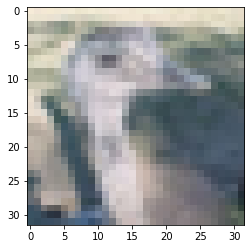

In [28]:
predict("./data/cifar10/test/bird/0025.png",model)